In [25]:
import os
import shutil
import utilities as rocku
import matplotlib.pyplot as plt
import tomopy
import numpy as np
import pandas as pd
import pprint
import dxchange
from pystackreg import StackReg
import multiprocessing as mp
import timeit
from tqdm import tqdm
import skimage as ski
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


In [5]:
# need to change
instrument = "/HFIR/CG1D"
# instrument = "/SNS/VENUS"
ipts="32819"
# scan_type = 'ct_scans'
scan_type = 'shared/processed_data/normalized'
# scan_type = 'alignment_calibration'

In [6]:
scan_loc = instrument + "/IPTS-"+ipts+"/" + scan_type
sorted(os.listdir(scan_loc))

['09_11_2024_AEANFTDRY_binned_by_5',
 '09_11_2024_AEANFTSAT',
 '09_12_2024_NOAEANFTSAT',
 '09_12_2024_NOAEANFTSAT_RIGID_BODY',
 '09_12_2024_NOAEANFTSAT_binned_by_2',
 '09_12_2024_NOAEANFTSAT_binned_by_3']

In [7]:
###################### need to change start
sample_name = "09_12_2024_NOAEANFTSAT_binned_by_3"
scan_dir = os.path.join(scan_loc, sample_name)
###################### need to change end

# Preprocess scan files

In [8]:
fname_list = os.listdir(scan_dir)
# fname_list.pop(0)
fname_list.sort()
print(len(fname_list))
fname_list

142


['scan1_0090_1209.tiff',
 'scan1_0090_1212.tiff',
 'scan1_0090_1215.tiff',
 'scan1_0090_1218.tiff',
 'scan1_0090_1221.tiff',
 'scan1_0090_1224.tiff',
 'scan1_0090_1227.tiff',
 'scan1_0090_1230.tiff',
 'scan1_0090_1233.tiff',
 'scan1_0090_1236.tiff',
 'scan1_0090_1239.tiff',
 'scan1_0090_1242.tiff',
 'scan1_0090_1245.tiff',
 'scan1_0090_1248.tiff',
 'scan1_0090_1251.tiff',
 'scan1_0090_1254.tiff',
 'scan1_0090_1257.tiff',
 'scan1_0090_1260.tiff',
 'scan1_0090_1263.tiff',
 'scan1_0090_1266.tiff',
 'scan1_0090_1269.tiff',
 'scan1_0090_1272.tiff',
 'scan1_0090_1275.tiff',
 'scan1_0090_1278.tiff',
 'scan1_0090_1281.tiff',
 'scan1_0090_1284.tiff',
 'scan1_0090_1287.tiff',
 'scan1_0090_1290.tiff',
 'scan1_0090_1293.tiff',
 'scan1_0090_1296.tiff',
 'scan1_0090_1299.tiff',
 'scan1_0090_1302.tiff',
 'scan1_0090_1305.tiff',
 'scan1_0090_1308.tiff',
 'scan1_0090_1311.tiff',
 'scan1_0090_1314.tiff',
 'scan1_0090_1317.tiff',
 'scan1_0090_1320.tiff',
 'scan1_0090_1323.tiff',
 'scan1_0090_1326.tiff',


In [9]:
to_rmv = [
# '090624_4batterystack_Radio1_0060_0587.tiff',
#  '090624_4batterystack_Radio1_0060_0588.tiff',
#  '090624_4batterystack_Radio1_0060_0589.tiff',
#     '090624_4batterystack_Radio1_0600_0590.tiff'
#  '20230919_dry_spun_fibers_rejoint_0300_0021.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0022.tiff',
#  '20230919_dry_spun_fibers_rejoint_0300_0023.tiff',
#  '20230919_wet_spun_fibers_0300_0006.tiff',
#  '20230919_wet_spun_fibers_0300_0007.tiff',
#  '20230919_wet_spun_fibers_0300_0008.tiff',
]
fname_list = rocku.remove_fnames(fname_list, to_rmv)

142
142


In [13]:
######### Scan
scan_raw = rocku.read_tiff_stack(scan_dir, fname_list)
print(scan_raw.shape)

142


(142, 5790, 5650)


Text(0.5, 1.0, 'After subtraction')

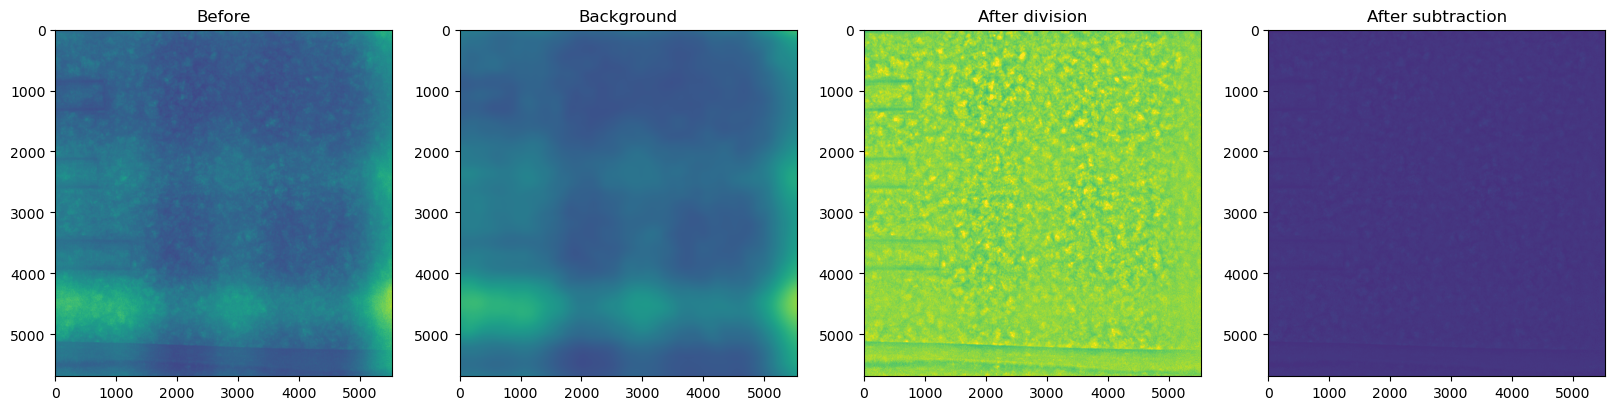

In [81]:
img_idx = 120
crop = True
# crop = False
crop_left = 50#320
crop_right = -70#1080
crop_top = 50
crop_bottom = -50
###################### need to change end
scan_crop = rocku.crop(scan_raw[img_idx], crop_left, crop_right, crop_top, crop_bottom, crop)
bkgd = ski.filters.gaussian(scan_crop, sigma=150, truncate=1)
img_bg_div = scan_crop/bkgd
img_bg_sub = scan_crop-bkgd
# img_bg_sub = img_bg_sub*(1/img_bg_sub.max())
f, ax = plt.subplots(1, 4, figsize=(20, 9))
ax[0].imshow(scan_crop, vmax=0.2, vmin=0)
ax[0].set_title('Before')
ax[1].imshow(bkgd, vmax=0.2, vmin=0)
ax[1].set_title('Background')
ax[2].imshow(img_bg_div, vmax=1.2, vmin=0)
ax[2].set_title('After division')
ax[3].imshow(img_bg_sub, )#vmax=1.2, vmin=0)
ax[3].set_title('After subtraction')

# Remove background

In [86]:
###################### need to change start
method = 'div'
# method = 'sub'
scan_bg_rmvd = np.empty((scan_raw.shape[0], scan_crop.shape[0], scan_crop.shape[1]), dtype=np.float32)
for i, ea_img in tqdm(enumerate(scan_raw)):
    _scan_crop = rocku.crop(ea_img, crop_left, crop_right, crop_top, crop_bottom, crop)
    _bkgd = ski.filters.gaussian(_scan_crop, sigma=150, truncate=1)
    if method == 'sub':
        _img_bg_rmvd = _scan_crop-_bkgd
    else:
        _img_bg_rmvd = _scan_crop/_bkgd
    scan_bg_rmvd[i] = _img_bg_rmvd

142it [15:31,  6.56s/it]


# Save files

In [87]:
scan_bg_rmvd.dtype

dtype('float32')

In [88]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/normalized/" + sample_name + '_bkgd_' + method
fname_list_save = fname_list[:]
print('Saving to {} ...'.format(save_to))
for i, e_name in tqdm(enumerate(fname_list_save)):
    fname = save_to + "/" + e_name
    dxchange.write_tiff(scan_bg_rmvd[i], fname=fname, overwrite=True, dtype='float32')

Saving to /HFIR/CG1D/IPTS-32819/shared/processed_data/normalized/09_12_2024_NOAEANFTSAT_binned_by_3_bkgd_div ...


142it [01:06,  2.15it/s]


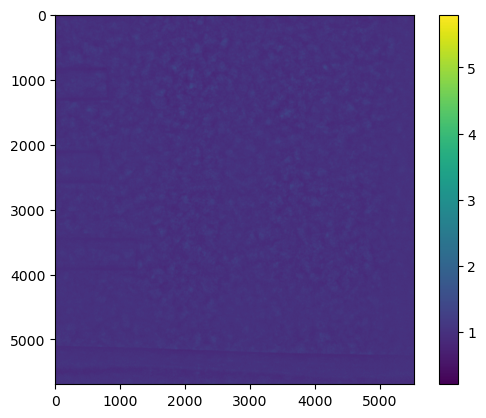

In [89]:
plt.imshow(scan_bg_rmvd[-1])
plt.colorbar()
plt.show()

In [90]:
scan_bg_rmvd[-1].dtype

dtype('float32')